In [12]:
import torch
import torch.nn as nn
import os

# TODO: figure out how to modularize this nicely
char_map_str = """
 <SPACE> 1
 a 2
 b 3
 c 4
 d 5
 e 6
 f 7
 g 8
 h 9
 i 10
 j 11
 k 12
 l 13
 m 14
 n 15
 o 16
 p 17
 q 18
 r 19
 s 20
 t 21
 u 22
 v 23
 w 24
 x 25
 y 26
 z 27
 ' 28
 """

def create_char_map(char_map_str):
    char_map, idx_map = {}, {}
    for line in char_map_str.strip().split("\n"):
        c, num = line.split()
        char_map[c] = int(num)
        idx_map[int(num)] = c
    return char_map, idx_map

char_map, idx_map = create_char_map(char_map_str)

def text_to_target(text, char_map):
    target = []
    for c in text:
        if c == " ":
            target.append(char_map["<SPACE>"])
        else:
            target.append(char_map[c])
    return torch.Tensor(target)

def target_to_text(target):

    text = ""
    for idx in target:
        idx = idx.item()
        if idx == 1:
            text += " "
        else:
            text += idx_map[idx]
    return text

def weights_init_unif(module, a, b):
    for p in module.parameters():
        nn.init.uniform_(p.data, a=a, b=b)

def load_from_checkpoint(model, optimizer, checkpoint_name, device):

    for root, dirs, files in os.walk('../'):
        for filename in files:
            if filename == checkpoint_name:
                path = os.path.join(root, filename)
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    return model, optimizer, epoch, loss

def save_checkpoint(model, optimizer, epoch, activation, batch_size):

    filename = "activation-{}_batch-size-{}_epoch-{}.pt".format(activation, batch_size, epoch)
    save_path = CHECKPOINT_DIR + filename 

    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, save_path)

In [3]:
DATASET_DIR = "/mnt/d/Datasets"
CHECKPOINT_DIR = "./checkpoints"

hparams = {
    "ADAM_lr": 10e-4,
    "batch_size": 3,
    "SGD_lr": 10e-5,
    "SGD_l2_penalty": 1e-5,
    "weights_init_a": -0.05,
    "weights_init_b": 0.05,
    "epochs": 10,
    "activation": "relu"
}

In [5]:
import torch
import torch.nn as nn
import torchaudio

def features_from_waveform(waveform):

    """
    Raw audio is transformed into 40-dimensional log mel-filter-bank (plus energy term) coefficients with deltas and delta-deltas, which reasults in 123 dimensional features.
    Each dimension is normalized to have zero mean and unit variance over the training set.
    Basically this is just MFCC but without taking DCT at the end, but for the sake of cleanliness, I'll stick with MFCC for now. 
    Also, I don't know what they mean by "energy term" (aren't the coefficients already energy terms?) so I'm omitting that.

    :param waveform: Time series data representing spoken input. Shape (channel, amplitude, time)
    :returns: "Spectrogram" of MFCC, delta, and delta-delta features. Shape (120, time)
    """

    # Waveform has channel first dimension, gives shape (1, ...) which causes shape problems when stacking features
    data = waveform.squeeze(dim=0)

    # Grab desired features
    mfcc_features = torchaudio.transforms.MFCC(log_mels=True)(data) # Takes in audio of dimension (..., time) returns (..., n_mfcc, time) where n_mfcc defaults to 40
    deltas = torchaudio.functional.compute_deltas(mfcc_features)
    delta_deltas = torchaudio.functional.compute_deltas(deltas)

    # Stack features together
    input_features = torch.cat((mfcc_features, deltas, delta_deltas), 0)

    # Normalize (0 mean, 1 std) features along time dimension
    input_features_normalized = nn.LayerNorm(input_features.shape[1], elementwise_affine=False)(input_features)

    return input_features_normalized

def preprocess(dataset):

    """
    Preprocesses dataset

    1. Convert waveforms to input features
    2. Convert transcripts to output class indices
    3. Get input sequence (feature) lengths before padding
    4. Get target lengths before padding
    5. Pad inputs and targets for consistent sizes

    This is fed into the DataLoader as the collate_fn, so keep in mind batch dimension.

    :param dataset: Batched raw waveforms with shape (batch_size, channel, amplitude, time)
    :returns inputs: Input "filter banks" to network (batch_size, num_channels, num_features, time). Padded along time dimension.
    :returns input_lengths: Python list of respective lengths (time) of inputs in batch 
    :returns targets: Transcript of sound converted to Tensor of integers instead of characters. Padded for uniform lengths within batch.
    :returns target_lengths: Python list of respective lenghts of transcripts in batch
    """

    # These are necessary for CTCLoss
    inputs = [] 
    targets = [] 
    # For these, CTCLoss expects them to be pre-padding
    input_lengths = [] 
    target_lengths = [] 

    # Each waveform has different lengths of time dimension, so we need to pad them. 
    # The built-in fn assumes trailing dimensions of all sequences are the same, so we have to transpose to pad the correct dimension since time (dim=1) varies, then transpose back after.

    for waveform, _, transcript, _, _, _ in dataset:
        # Output of features_from_waveform have dim: (120, time)
        features = features_from_waveform(waveform).transpose(0, 1)
        inputs.append(features)
        input_lengths.append(features.shape[0])

        target = text_to_target(transcript.lower(), char_map)
        targets.append(target)
        target_lengths.append(len(target))

    # Need to add back (unsqueeze) channel dimension
    # Returns dimensions: (batch, time, features), so transpose appropriately
    # Side note: this will pad all samples within the same batch (not overall) to be the same dimensions
    # This transformation doesn't affect the model architecture since we are only flattening/connecting the feature dimension, not the time one (nn.Linear allows for this flexibility), so we can have variable length inputs across batches in this regard
    inputs = nn.utils.rnn.pad_sequence(inputs, batch_first=True).unsqueeze(1).transpose(2, 3) 

    # This will pad with 0, which represents the blank, but this shouldn't be a problem since we're providing the target_length of the unpadded target
    targets = nn.utils.rnn.pad_sequence(targets, batch_first=True)

    return inputs, input_lengths, targets, target_lengths


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv_Layer(nn.Module):

    def __init__(self, in_channels, out_channels, kernel, activation, dropout, pool=None, stride=1):
        super(Conv_Layer, self).__init__()

        # Use padding so that feature maps don't decrease in size throughout network. Makes things wrt dimensions nice when moving to FC layers.
        # Math says that we should pad by (kernel_size[0]//2, kernel_size[1]//2) to keep dimensions the same, in our case this is (1, 2)  
        # However, paper says they only pad along time axis, so number of features will decrease 
        self.kernel = kernel
        self.padding = (0, self.kernel[1]//2)
        self.stride = stride

        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=self.kernel, padding=self.padding, stride=self.stride)

        self.maxout = activation == "maxout"
        if activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "prelu":
            # Need to use module instead of functional since it has a parameter and needs to be pushed to cuda
            self.activation = nn.PReLU(init=0.1)
        elif activation == "maxout":
            # Better results (theoretically), worse memory usage
            self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel, padding=(0,kernel[1]//2))
        else:
            raise Exception("Not a supported activation function. Choose between 'relu', 'prelu', or 'maxout'.")
       
        # Using Dropout module vs functional will automatically disable it during model.eval()
        self.dropout = nn.Dropout(p=dropout)

        # Pool reduces dimension: ((old - (pool_dim - 1) - 1) / pool_dim) + 1, turns out to do 118 -> 39 in our case
        self.pool = pool

    def forward(self, x):
        if self.maxout:
            x = self.conv_maxout(x)
        else:
            x = self.conv(x)
            x = self.activation(x)

        if self.pool:
            x = nn.MaxPool2d(kernel_size=self.pool)(x)

        x = self.dropout(x)
        return x

    def conv_maxout(self, x):
        # 2-way maxout creates 2 versions of a layer and maxes them, that's it
        
        x1, x2 = self.conv(x), self.conv2(x)
        return torch.maximum(x1, x2)

    def get_new_feature_map_dimension(self, in_dim):
        # Convolution layer + operations will decrease the dimensions of the computed feature maps.
        # This is important for figuring out the input dimensions of the first FC layer
        # In our case, we only care about the feature (0th) dimension
        # out = ((in + 2 * padding - kernel) // stride) + 1
        # in pooling layer, stride is defaulted to kernel


        # For feature maps, Conv2d: 3x5 conv (with appropriate padding) will decrease frequency dim by 2
        # MaxPool2d: 3x1 pooling decreases frequency dim by 2
        out = (in_dim + 2 * self.padding[0] - self.kernel[0]) // self.stride + 1
        if self.pool:
            out = (out - self.pool[0]) // self.pool[0] + 1
            
        return out  

class FC_Layer(nn.Module):

    def __init__(self, in_dim, out_dim, activation, dropout):
        super(FC_Layer, self).__init__()

        self.fc = nn.Linear(in_dim, out_dim)
        
        self.maxout = activation == "maxout"
        if activation == "relu":
            self.activation = nn.ReLU()
        elif activation == "prelu":
            # Need to use module instead of functional since it has a parameter and needs to be pushed to cuda
            self.activation = nn.PReLU(init=0.1)
        elif activation == "maxout":
            # Better results (theoretically), worse memory usage
            self.fc2 = nn.Linear(in_dim, out_dim)
        else:
            raise Exception("Not a supported activation function. Choose between 'relu', 'prelu', or 'maxout'.")
        
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        if self.maxout:
            x = self.fc_maxout(x)
        else:
            x = self.fc(x)
            x = self.activation(x)
        x = self.dropout(x)
        return x

    def fc_maxout(self, x):
        
        x1, x2 = self.fc(x), self.fc2(x)
        return torch.maximum(x1, x2)

class ASR_1(nn.Module):

        """
        Unlike the other layers, the first convolutional layer is followed by a pooling layer. 
        The pooling size is 3 × 1, which means we only pool over the frequency axis. The filter size is 3 × 5 across the layers. 
        The model has 256 feature maps in the first four convolutional layers and 256 feature maps in the remaining six convolutional layers. 
        Each fully-connected layer has 1024 units. Maxout with 2 piece-wise linear functions is used as the activation function.

        We differ from the given model by using ReLU instead of Maxout for the activation function. This is simply due to memory constraints on 
        available hardware. 
        """ 

        def __init__(self, in_dim, num_classes, num_features, activation, dropout):
            
            super(ASR_1, self).__init__()

            self.cnn_layers = nn.Sequential(
                            Conv_Layer(in_channels=in_dim, out_channels=128, kernel=(3,5), activation="relu", dropout=0, pool=(3,1)),
                            Conv_Layer(128, 128, (3,5), activation, dropout),
                            Conv_Layer(128, 128, (3,5), activation, dropout),
                            Conv_Layer(128, 128, (3,5), activation, dropout),
                            Conv_Layer(128, 256, (3,5), activation, dropout),
                            Conv_Layer(256, 256, (3,5), activation, dropout),
                            Conv_Layer(256, 256, (3,5), activation, dropout),
                            Conv_Layer(256, 256, (3,5), activation, dropout),
                            Conv_Layer(256, 256, (3,5), activation, dropout),
                            Conv_Layer(256, 256, (3,5), activation, dropout)
            )

            # Features dimenion of resulting feature map: num_features = 120 -> 39 (after first conv + pool) - 2 (conv[2-10]) * 9 = 39 - 18 = 21
            # So in our use case, first fc layer should have dimensions = 256 * 21 = 5376

            fc_in = num_features
            for layer in self.cnn_layers.children():
                fc_in = layer.get_new_feature_map_dimension(fc_in)

            self.fc_layers = nn.Sequential(
                            FC_Layer(in_dim=256 * fc_in, out_dim=1024, activation=activation, dropout=dropout),
                            FC_Layer(1024, 1024, activation, dropout),
                            FC_Layer(1024, 1024, activation, dropout),
                            FC_Layer(1024, num_classes, activation, 0)
            )

        def forward(self, x):
            x = self.cnn_layers(x) # output shape (batch_size, channels, features, time)
            x = x.view(x.shape[0], x.shape[1] * x.shape[2], x.shape[3]) # flattens channel and feature dimensions into one
            x = x.transpose(1, 2) # (batch_size, time, flattened_features)

            x = self.fc_layers(x) # FC layer input: (N, *, H_{in}) where * means any number of additional dimensions and H_in=in_features

            x = F.log_softmax(x, dim=2)
            return x
            

In [7]:
import torch

def train(model, train_loader, criterion, optimizer, epoch, device):
    model.train()
    data_len = len(train_loader.dataset)
    for batch_num, data in enumerate(train_loader): 
        inputs, input_lengths, targets, target_lengths = data
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        # this is shape (batch size, time, num_classes)
        output = model(inputs)

        # output passed in should be of shape (time, batch size, num_classes)
        output = output.transpose(0, 1)
        loss = criterion(output, targets, input_lengths, target_lengths)
        loss.backward()

        optimizer.step() 

        if batch_num % 100 == 0 or batch_num == data_len:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_num * len(inputs), data_len,
                    100. * batch_num / len(train_loader), loss.item()))

In [8]:
import torch

def test(model, test_loader, criterion, device):
    model.eval()
    with torch.no_grad():
        for inputs, input_lengths, targets, target_lengths in test_loader:

            output = model(inputs)
            output = output.transpose(0, 1)
            loss = criterion(output, targets, input_lengths, target_lengths)
            
            # TODO: Decoding algo
            # Transpose back so that we can iterate over batch dimension
            output = output.transpose(0, 1)
            for log_probs in output:
                guessed_target = greedy_decode(torch.argmax(log_probs, dim=1))

def greedy_decode(log_probs):

    # TODO: incorporate target_length in here to reduce amount of work necessary
    transcript = []
    blank_seen = False
    prev = None
    for i in log_probs:
        if i == prev and not blank_seen:
           continue
        elif i == 0:
            blank_seen = True
        else:
            transcript.append(i)
            blank_seen = False

    return target_to_text(transcript)

cpu


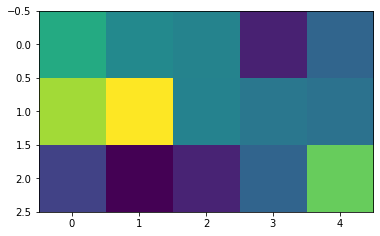

In [15]:
import numpy as np
import matplotlib.pyplot as plt
# todo: get cuda working
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# train_dataset = torchaudio.datasets.LIBRISPEECH(DATASET_DIR, url="train-clean-100", download=True)
# dev_dataset = torchaudio.datasets.LIBRISPEECH(DATASET_DIR, url="dev-clean", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH(DATASET_DIR, url="test-clean", download=True)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams["batch_size"], shuffle=True, collate_fn=preprocess, pin_memory=use_cuda)

# dev_loader = torch.utils.data.DataLoader(dev_dataset, batch_size=hparams["batch_size"], shuffle=True, collate_fn=preprocess, pin_memory=use_cuda)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=hparams["batch_size"], shuffle=False, collate_fn=preprocess, pin_memory=use_cuda)

# 1 channel input from feature spectrogram, 29 dim output from char_map + blank for CTC, 120 features
net = ASR_1(in_dim=1, num_classes=29, num_features=120, activation=hparams["activation"], dropout=0.3)
net.to(device)
weights_init_unif(net, hparams["weights_init_a"], hparams["weights_init_b"])

# ADAM loss w/ lr=10e-4, batch size 20, initial weights initialized uniformly from [-0.05, 0.05], dropout w/ p=0.3 used in all layers except in and out
# for fine tuning: SGD w/ lr 10e-5, l2 penalty w/ coeff=1e-5

criterion = nn.CTCLoss().to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=hparams["ADAM_lr"])
finetune_optimizer = torch.optim.SGD(net.parameters(), lr=hparams["SGD_lr"], weight_decay=hparams["SGD_l2_penalty"])

# for epoch in range(1, hparams["epochs"] + 1):
#     train(net, train_loader, criterion, optimizer, epoch, device)
#     save_checkpoint(net, optimizer, epoch, hparams["activation"], hparams["batch_size"])

    
# TODO: Where/when to do dev set?

net, _, _, _ = load_from_checkpoint(net, optimizer, "activation-relu_batch-size-3_epoch-3.pt", device)

pass
filter_list = list(net.children())[0][0].conv.weight.data
im = filter_list[0]
im = np.transpose(im, (1,2,0))
plt.imshow(im)
plt.show()

In [26]:
filter_list = list(net.children())[0][1].conv.weight.data
im = filter_list[0]
im = np.transpose(im, (1,2,0))
plt.imshow(im)
plt.show()

TypeError: Invalid shape (3, 5, 128) for image data